# For the actual KIID Setting

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random, copy, os
import pandas as pd
random.seed(42)
np.random.seed(42)
import time
from scipy.optimize import linprog
from sklearn.metrics.pairwise import manhattan_distances
from prettytable import PrettyTable

In [17]:
%run wrapper_classes.ipynb

In [18]:
%run algorithm_functions.ipynb

# 0. Set up the experiment
## 0.1 Read in cleaned up, processed dataframe of drivers and requests

In [19]:
filtered_df = pd.read_csv('filtered data/filtered_df.csv')

In [20]:
def run_experiment(num_U,num_V,driver_quotas,rider_tolerances, alphas, betas, gammas, num_loops, verbose = False):
    driver_entries = []

    #1. First read in the drivers and riders as objects
    hack_licenses = filtered_df['hack_license'].unique()

    print(len(hack_licenses))
    print(len(filtered_df))
    chosen_licenses = np.random.choice(hack_licenses,size = num_U)

    for i in range(chosen_licenses.shape[0]):
        entries = filtered_df.loc[filtered_df['hack_license'] == chosen_licenses[i]]
        driver_entries.append(entries.sample(n = 1))

    driver_entries = pd.concat(driver_entries)
    rider_entries = filtered_df.sample(n = num_V)

    drivers = []
    requests = []

    d_id = 0
    for index, row in driver_entries.iterrows():
        init_lat_bin = row['init_lat_bin']
        init_long_bin = row['init_long_bin']

        pickup_lat_bin = row['pickup_lat_bin']
        pickup_long_bin = row['pickup_long_bin']

        dropoff_lat_bin = row['dropoff_lat_bin']
        dropoff_long_bin = row['dropoff_long_bin']

        driver_race = row['driver_race']
        driver_gender = row['driver_gender']

        drivers.append(Driver(d_id = d_id, driver_race = driver_race, driver_gender = driver_gender, pickup_lat_bin = pickup_lat_bin,\
                              pickup_long_bin = pickup_long_bin, driver_init_lat = init_lat_bin, driver_init_long = init_long_bin,\
                              quota = random.choice(driver_quotas), capacity = driver_capacity))
        d_id += 1

    r_id = 0
    for index, row in rider_entries.iterrows():
        pickup_lat_bin = row['pickup_lat_bin']
        pickup_long_bin = row['pickup_long_bin']

        dropoff_lat_bin = row['dropoff_lat_bin']
        dropoff_long_bin = row['dropoff_long_bin']

        driver_race = row['driver_race']
        driver_gender = row['driver_gender']

        pickup_latitude = row['pickup_latitude']
        pickup_longitude = row['pickup_longitude']

        dropoff_latitude = row['dropoff_latitude']
        dropoff_longitude = row['dropoff_longitude']

        request_gender = row['requests_gender']
        request_race = row['requests_race']

        requests.append(Request(pickup_lat_bin = pickup_lat_bin, pickup_long_bin = pickup_long_bin, dropoff_lat_bin = dropoff_lat_bin,\
                                dropoff_long_bin = dropoff_long_bin, pickup_latitude = pickup_latitude, pickup_longitude = pickup_longitude,\
                                dropoff_latitude = dropoff_latitude, dropoff_longitude = dropoff_longitude, requests_gender = request_gender,\
                                requests_race = request_race, arrival_rate = rider_arrival_rate, distance = None, utility = None))
        r_id +=1

    set_unique_ids(drivers)
    set_unique_ids(requests)
    for r in requests:
        r.set_individual_rider_tolerance(random.choice(rider_tolerances)) #uniformly sample rider patience between {1, 2}


    #2. Set the probability matrix
    probability_matrix = np.empty([num_U,num_V])
    for row in range(num_U):
        for col in range(num_V):
            driver_race = drivers[row].race
            request_race = requests[col].race
            if driver_race == 'white' and request_race == 'white':
                probability_matrix[row,col] = 0.6
            elif driver_race == 'white' and request_race == 'black':
                probability_matrix[row,col] = 0.1
            elif driver_race == 'black' and request_race == 'white':
                probability_matrix[row,col] = 0.1
            else:
                probability_matrix[row,col] = 0.3

    #3. Construct utility matrix
    driver_pos = np.empty([num_U,2])
    rider_pos = np.empty([num_V,2])
    target_pos = np.empty([num_V,2])

    for driver_idx in range(num_U):
        driver_pos[driver_idx,0] = drivers[driver_idx].init_latitude
        driver_pos[driver_idx,1] = drivers[driver_idx].init_longitude

    for rider_idx in range(num_V):
        rider_pos[rider_idx,0] = requests[rider_idx].start_latitude
        rider_pos[rider_idx,1] = requests[rider_idx].start_longitude

        target_pos[rider_idx,0] = requests[rider_idx].end_latitude
        target_pos[rider_idx,1] = requests[rider_idx].end_longitude

    driver_rider_dis = manhattan_distances(driver_pos,rider_pos)
    trip_length = np.sum(np.abs(target_pos - rider_pos),axis = -1)
    trip_length = np.tile(trip_length,(num_U,1))

        #3.1Set the utility from three sides
    driver_utility = trip_length - driver_rider_dis
    driver_utility_matching = np.ones([num_U,num_V])
    rider_utility = -driver_rider_dis# + np.max(driver_rider_dis)
    rider_utility_matching = np.ones([num_U,num_V])
    operator_utility = trip_length


        #3.2scale them by a constant to be greater than 0
    driver_utility -= np.min(driver_utility)
    rider_utility -= np.min(rider_utility)

    if verbose:
        #print statistics of the utility matrix
        t = PrettyTable(['','mean', 'std', 'min', 'max'])
        t.title = 'utility statistics'
        t.add_row(['operator utility'] + [operator_utility.mean(),operator_utility.std(),operator_utility.min(),operator_utility.max() ])
        t.add_row(['driver utility'] + [driver_utility.mean(),driver_utility.std(),driver_utility.min(),driver_utility.max() ])
        t.add_row(['driver utility matching'] + [driver_utility_matching.mean(),driver_utility_matching.std(),driver_utility_matching.min(),driver_utility_matching.max() ])
        t.add_row(['rider utility'] + [rider_utility.mean(),rider_utility.std(),rider_utility.min(),rider_utility.max() ])
        t.add_row(['rider utility matching'] + [rider_utility_matching.mean(),rider_utility_matching.std(),rider_utility_matching.min(),rider_utility_matching.max() ])
        print(t)

    #4. solve the LPs

        #4.1 Operator LP TSGF
    bound = np.reshape(np.array([0, 1]), (1, 2))
    bounds_operator = np.tile(bound, (num_U * num_V, 1))
    profit_c = get_operator_objective_kiid_sk(operator_utility * probability_matrix)
    operator_A, operator_b = get_inequalities_operator_kiid_sk(drivers, requests, probability_matrix)
    operator_x = linprog(profit_c, operator_A, operator_b, bounds=bounds_operator, method='highs')

        #4.2 Driver LP TSGF
    driver_c = get_driver_objective_kiid_sk(driver_utility)
    driver_A, driver_b, driver_bounds = get_inequalities_driver_kiid_sk(drivers, requests, probability_matrix, driver_utility)
    driver_x = linprog(driver_c, driver_A, driver_b, bounds=driver_bounds, method='highs')

        #4.3 Rider LP TSGF
    rider_c = get_rider_objective_kiid_sk(rider_utility)
    rider_A, rider_b, rider_bounds = get_inequalities_rider_kiid_sk(drivers, requests, probability_matrix, rider_utility)
    rider_x = linprog(rider_c, rider_A, rider_b, bounds=rider_bounds, method='highs')

        #4.4 Driver LP Matching
    driver_c_matching = get_driver_objective_kiid_sk(driver_utility_matching)
    driver_A_matching, driver_b_matching, driver_bounds_matching = get_inequalities_driver_kiid_sk(drivers, requests,probability_matrix, driver_utility_matching)
    driver_x_matching = linprog(driver_c_matching, driver_A_matching, driver_b_matching, bounds=driver_bounds_matching,method='highs')

        #4.5 Rider LP Matching
    rider_c_matching = get_rider_objective_kiid_sk(rider_utility_matching)
    rider_A_matching, rider_b_matching, rider_bounds_matching = get_inequalities_rider_kiid_sk(drivers, requests,probability_matrix,rider_utility_matching)
    rider_x_matching = linprog(rider_c_matching, rider_A_matching, rider_b_matching, bounds=rider_bounds_matching, method='highs')

        #4.6 reshape the solutions
    operator_x_2d = np.reshape(operator_x.x, [num_U, num_V])
    driver_x_2d = np.reshape(driver_x.x[0:num_U * num_V], [num_U, num_V])
    rider_x_2d = np.reshape(rider_x.x[0:num_U * num_V], [num_U, num_V])
    driver_x_2d_matching = np.reshape(driver_x_matching.x[0:num_U * num_V], [num_U, num_V])
    rider_x_2d_matching = np.reshape(rider_x_matching.x[0:num_U * num_V], [num_U, num_V])

        #4.7 Calculate the statistics
    operator_operator_ub = np.sum(np.sum(operator_x_2d * operator_utility * probability_matrix, axis=-1), axis=-1)
    operator_driver_ub, operator_rider_ub = util_to_fairness(drivers, requests,
                                                             np.sum(operator_x_2d * driver_utility * probability_matrix,
                                                                    axis=1),
                                                             np.sum(operator_x_2d * rider_utility * probability_matrix,
                                                                    axis=0))

    driver_operator_ub = np.sum(np.sum(driver_x_2d * operator_utility * probability_matrix, axis=-1), axis=-1)
    driver_driver_ub, driver_rider_ub = util_to_fairness(drivers, requests,
                                                         np.sum(driver_x_2d * driver_utility * probability_matrix, axis=1),
                                                         np.sum(driver_x_2d * rider_utility * probability_matrix, axis=0))

    rider_operator_ub = np.sum(np.sum(rider_x_2d * operator_utility * probability_matrix, axis=-1), axis=-1)
    rider_driver_ub, rider_rider_ub = util_to_fairness(drivers, requests,
                                                       np.sum(rider_x_2d * driver_utility * probability_matrix, axis=1),
                                                       np.sum(rider_x_2d * rider_utility * probability_matrix, axis=0))

    driver_operator_ub_matching = np.sum(np.sum(driver_x_2d_matching * operator_utility * probability_matrix, axis=-1),
                                         axis=-1)
    driver_driver_ub_matching, driver_rider_ub_matching = util_to_fairness(drivers, requests, np.sum(
        driver_x_2d_matching * driver_utility * probability_matrix, axis=1), np.sum(
        driver_x_2d_matching * rider_utility * probability_matrix, axis=0))

    rider_operator_ub_matching = np.sum(np.sum(rider_x_2d_matching * operator_utility * probability_matrix, axis=-1),
                                        axis=-1)
    rider_driver_ub_matching, rider_rider_ub_matching = util_to_fairness(drivers, requests, np.sum(
        rider_x_2d_matching * driver_utility * probability_matrix, axis=1), np.sum(
        rider_x_2d_matching * rider_utility * probability_matrix, axis=0))

    operator_ubs = [operator_operator_ub, operator_driver_ub, operator_rider_ub]
    driver_ubs = [driver_operator_ub, driver_driver_ub, driver_rider_ub]
    rider_ubs = [rider_operator_ub, rider_driver_ub, rider_rider_ub]
    driver_ubs_matching = [driver_operator_ub_matching, driver_driver_ub_matching, driver_rider_ub_matching]
    rider_ubs_matching = [rider_operator_ub_matching, rider_driver_ub_matching, rider_rider_ub_matching]

    upper_bounds = np.array([operator_ubs[0], driver_ubs[1], rider_ubs[2]])
    if verbose:
        t = PrettyTable(['', 'profit', 'driver fairness', 'rider fairness'])
        t.title = 'LP solutions'
        t.add_row(['upper bounds'] + list(upper_bounds))
        t.add_row(['operator LP'] + list(operator_ubs))
        t.add_row(['driver LP'] + list(driver_ubs))
        t.add_row(['driver matching LP'] + list(driver_ubs_matching))
        t.add_row(['rider LP'] + list(rider_ubs))
        t.add_row(['rider matching LP'] + list(rider_ubs_matching))
        print(t)

    #5. run the experiment
    requests_copy = copy.deepcopy(requests)
    results_TSGF_inner = []
    results_matching_inner = []

    for n in range(len(alphas)):
        t0 = time.time()
        alpha = alphas[n]
        beta = betas[n]
        gamma = gammas[n]

        match_results = np.zeros([num_loops,num_U,num_V])
        for i in range(num_loops):
            drivers_copy = [copy.deepcopy(d) for d in drivers]
            run_TSGF_express(i,match_results,requests_copy, drivers_copy, probability_matrix, operator_x_2d,driver_x_2d, rider_x_2d,alpha=alpha, beta = beta, gamma = gamma)

        driver_mean_utility = np.mean(np.sum(match_results * driver_utility,axis = -1),axis = 0)
        rider_mean_utility = np.mean(np.sum(match_results * rider_utility,axis = -2),axis = 0)
        operator_mean_utility = np.mean(np.sum(np.sum(match_results * operator_utility,axis = -1),axis = -1),axis = 0)

        expost_d_fairness, expost_r_fairness = util_to_fairness(drivers,requests,driver_mean_utility,rider_mean_utility)
        results_TSGF_inner.append([operator_mean_utility, expost_d_fairness,expost_r_fairness])

        #FOR Matching

        match_results = np.zeros([num_loops,num_U,num_V])
        for i in range(num_loops):
            drivers_copy = [copy.deepcopy(d) for d in drivers]
            run_TSGF_express(i,match_results,requests_copy, drivers_copy, probability_matrix, operator_x_2d,driver_x_2d_matching, rider_x_2d_matching,alpha=alpha, beta = beta, gamma = gamma)

        driver_mean_utility = np.mean(np.sum(match_results * driver_utility,axis = -1),axis = 0)
        rider_mean_utility = np.mean(np.sum(match_results * rider_utility,axis = -2),axis = 0)
        operator_mean_utility = np.mean(np.sum(np.sum(match_results * operator_utility,axis = -1),axis = -1),axis = 0)

        expost_d_fairness, expost_r_fairness = util_to_fairness(drivers,requests,driver_mean_utility,rider_mean_utility)
        results_matching_inner.append([operator_mean_utility, expost_d_fairness,expost_r_fairness])
        if verbose:
            print(alpha, beta, gamma, time.time() - t0)


    results = np.array(results_TSGF_inner)
    results_matching = np.array(results_matching_inner)

    profit_crs = np.reshape(results[:,0] / upper_bounds[0],[alphas.shape[0],1])
    driver_fairness_crs = np.reshape(results[:,1] / upper_bounds[1],[alphas.shape[0],1])
    rider_fairness_crs = np.reshape(results[:,2] / upper_bounds[2],[alphas.shape[0],1])

    profit_crs_matching = np.reshape(results_matching[:,0] / upper_bounds[0],[alphas.shape[0],1])
    driver_fairness_crs_matching = np.reshape(results_matching[:,1] / upper_bounds[1],[alphas.shape[0],1])
    rider_fairness_crs_matching = np.reshape(results_matching[:,2] / upper_bounds[2],[alphas.shape[0],1])

    TSGF_crs = np.hstack([profit_crs, driver_fairness_crs, rider_fairness_crs])
    matching_crs = np.hstack([profit_crs_matching, driver_fairness_crs_matching, rider_fairness_crs_matching])


    return TSGF_crs, matching_crs


# Run the Experiment

In [21]:
start_t = time.time()

In [22]:
num_trials = 100
num_loops = 100
num_ticks = 11

In [23]:
num_U = 49
num_V = 172

driver_quotas = [3] #driver patience set to 3
rider_tolerances = [1,2]
driver_capacity = 1
rider_arrival_rate = 1

In [24]:
alphas = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
betas = (1-alphas) / 2
gammas = (1-alphas) / 2

In [25]:
t0 = time.time()
results_TSGF, results_matching = np.zeros([num_trials, num_ticks,3]), np.zeros([num_trials, num_ticks,3])
for i in range(num_trials):
    print(i)
    results_TSGF_single, results_matching_single = run_experiment(num_U,num_V,driver_quotas,rider_tolerances, alphas, betas, gammas, num_loops)
    results_TSGF[i,:,:] =  results_TSGF_single
    results_matching[i,:,:] =  results_matching_single
print(time.time() - t0)

0
10814
35109
1
10814
35109
2
10814
35109
3
10814
35109
4
10814
35109
5
10814
35109
6
10814
35109
7
10814
35109
8
10814
35109
9
10814
35109
10
10814
35109
11
10814
35109
12
10814
35109
13
10814
35109
14
10814
35109
15
10814
35109
16
10814
35109
17
10814
35109
18
10814
35109
19
10814
35109
20
10814
35109
21
10814
35109
22
10814
35109
23
10814
35109
24
10814
35109
25
10814
35109
26
10814
35109
27
10814
35109
28
10814
35109
29
10814
35109
30
10814
35109
31
10814
35109
32
10814
35109
33
10814
35109
34
10814
35109
35
10814
35109
36
10814
35109
37
10814
35109
38
10814
35109
39
10814
35109
40
10814
35109
41
10814
35109
42
10814
35109
43
10814
35109
44
10814
35109
45
10814
35109
46
10814
35109
47
10814
35109
48
10814
35109
49
10814
35109
50
10814
35109
51
10814
35109
52
10814
35109
53
10814
35109
54
10814
35109
55
10814
35109
56
10814
35109
57
10814
35109
58
10814
35109
59
10814
35109
60
10814
35109
61
10814
35109
62
10814
35109
63
10814
35109
64
10814
35109
65
10814
35109
66
10814
35109
67
10

In [26]:
results_TSGF_mean = np.mean(results_TSGF,axis = 0)
results_matching_mean = np.mean(results_matching,axis = 0)
results_TSGF_bar = np.std(results_TSGF,axis = 0)
results_matching_bar = np.std(results_matching,axis = 0)

In [27]:
print(results_TSGF_mean)

[[0.39270993 0.47719283 0.52406372]
 [0.41507242 0.47283716 0.51011173]
 [0.43648338 0.46866774 0.4980632 ]
 [0.45674501 0.46306027 0.48647078]
 [0.47588004 0.45518981 0.4692694 ]
 [0.49785375 0.4503423  0.45402803]
 [0.51798862 0.44305136 0.44097189]
 [0.53592487 0.43389624 0.42733265]
 [0.55597298 0.42227985 0.41019661]
 [0.57313801 0.41199587 0.39655055]
 [0.59266791 0.40134679 0.38282513]]


In [28]:
print(results_matching_mean)

[[0.26633036 0.39665864 0.44262679]
 [0.3012589  0.40158141 0.43702717]
 [0.33361811 0.40415151 0.43023073]
 [0.36793472 0.40740758 0.42377221]
 [0.40034848 0.4074036  0.41711916]
 [0.43344441 0.40926322 0.41238564]
 [0.46556774 0.40928716 0.40652904]
 [0.4992407  0.40871236 0.40059879]
 [0.52989981 0.40818569 0.39478344]
 [0.56286368 0.4042325  0.38624978]
 [0.58996489 0.40001405 0.38018263]]


In [29]:
alphas = np.array(alphas)
betas = np.array(betas)
gammas = np.array(gammas)

alphas = np.reshape(alphas,(num_ticks,1))
betas = np.reshape(betas,(num_ticks,1))
gammas = np.reshape(gammas,(num_ticks,1))

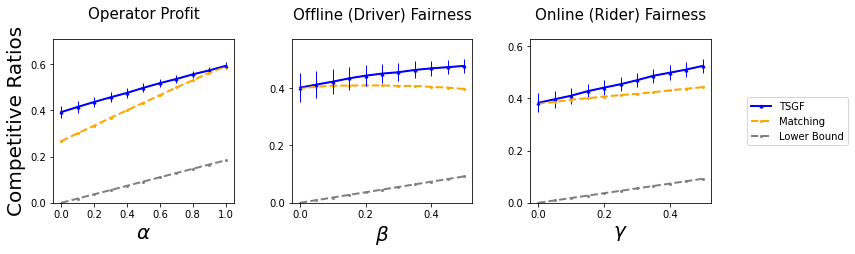

In [40]:
fig, axes = plt.subplots(1, 3)
max_y = np.max(results_TSGF_mean[:,0]) * 1.2
axes[0].plot(alphas, results_TSGF_mean[:,0], color='blue', label='TSGF',marker='^',linestyle='solid', ms = 3, linewidth =2)
axes[0].errorbar(alphas, results_TSGF_mean[:,0], results_TSGF_bar[:,0], color='blue',marker='^',linestyle='solid', ms = 2, linewidth =1)
axes[0].plot(alphas, results_matching_mean[:,0], color='orange', label='Matching', linestyle='dashed',marker='o',ms = 2,linewidth = 2)
axes[0].plot(alphas, alphas / (2 * np.e), color='gray', label='Lower Bound', linestyle='dashed',marker='o',ms = 2,linewidth = 2)
axes[0].set_ylim(0, max_y)
axes[0].set_aspect(1/max_y)
axes[0].set_xticks([0,0.2,0.4,0.6,0.8,1])
axes[0].set_xlabel(r'$\alpha$',fontsize = 20)
axes[0].set_ylabel('Competitive Ratios', fontsize = 20)
axes[0].set_title('Operator Profit', pad=20, fontsize = 15)
axes[0].set_yticks(np.arange(0, max_y, 0.2))

max_y = np.max(results_TSGF_mean[:,1]) * 1.2
axes[1].plot(betas, results_TSGF_mean[:,1], color='blue', label='TSGF',marker='^', ms = 3, linewidth =2)
axes[1].plot(betas, results_matching_mean[:,1], color='orange', label='Matching', linestyle='dashed',marker='o',ms = 2,linewidth = 2)
axes[1].errorbar(betas, results_TSGF_mean[:,1], results_TSGF_bar[:,1], color='blue',marker='^',linestyle='solid', ms = 2, linewidth =1)
axes[1].plot(betas, betas / (2 * np.e), color='gray', label='Lower Bound', linestyle='dashed',marker='o',ms = 2,linewidth = 2)
axes[1].set_ylim(0, max_y)
axes[1].set_aspect(0.5/max_y)
axes[1].set_xticks([0,0.2,0.4])
axes[1].set_xlabel(r'$\beta$',fontsize = 20)
axes[1].set_title('Offline (Driver) Fairness', pad=20, fontsize = 15)
axes[1].set_yticks(np.arange(0, max_y, 0.2))

max_y = np.max(results_TSGF_mean[:,2]) * 1.2
axes[2].plot(gammas, results_TSGF_mean[:,2], color='blue', label='TSGF',marker='^', ms = 3, linewidth =2)
axes[2].errorbar(gammas, results_TSGF_mean[:,2], results_TSGF_bar[:,2], color='blue', marker='^',linestyle='solid', ms = 2, linewidth =1)
axes[2].plot(gammas, results_matching_mean[:,2], color='orange', label='Matching', linestyle='dashed',marker='o',ms = 2,linewidth = 2)
axes[2].plot(gammas, gammas / (2 * np.e), color='gray', label='Lower Bound', linestyle='dashed',marker='o',ms = 2,linewidth = 2)
axes[2].set_ylim(0, max_y)
axes[2].set_aspect( 0.5/max_y)
axes[2].set_xticks([0,0.2,0.4])
axes[2].set_xlabel(r'$\gamma$',fontsize = 20)
axes[2].set_title('Online (Rider) Fairness', pad=20, fontsize = 15)
axes[2].set_yticks(np.arange(0, max_y, 0.2))
axes[2].legend(loc=(1.2,0.35))

fig.set_size_inches(12, 12)
fig.tight_layout(pad=1, w_pad=3.5, h_pad=2.5)
plt.savefig('plots/figure1',facecolor='white', transparent=False, bbox_inches='tight',dpi=600)
plt.show()